In [56]:
import os
import time
import shutil
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
import warnings
warnings.filterwarnings("ignore")

In [35]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def split_data(tr_dir, ts_dir):
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)


    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    
    return train_df, valid_df, test_df

In [36]:
def create_model_data (train_df, valid_df, test_df, batch_size):    
    img_size = (224, 224)
    channels = 3 
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen

In [37]:
def show_images(gen):
    g_dict = gen.class_indices       
    classes = list(g_dict.keys())    
    images, labels = next(gen)       
    length = len(labels)       
    sample = min(length, 25)    
    plt.figure(figsize= (20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]   
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [38]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience 
        self.stop_patience = stop_patience 
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch 
        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1   
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf 
        self.best_weights = self.model.get_weights() 
        self.initial_weights = self.model.get_weights()   

    def on_train_begin(self, logs= None):
        self.ask_permission = 0
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr = lr
        acc = logs.get('accuracy')  
        v_acc = logs.get('val_accuracy') 
        loss = logs.get('loss')  
        v_loss = logs.get('val_loss')  

        if acc < self.threshold: 
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc 

            if acc > self.highest_tracc: 
                self.highest_tracc = acc 
                self.best_weights = self.model.get_weights() 
                self.count = 0 
                self.stop_count = 0 
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  
            else:
                if self.count >= self.patience - 1: 
                    lr = lr * self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    self.count = 0 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 
        else: 
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: 
                self.lowest_vloss = v_loss 
                self.best_weights = self.model.get_weights() 
                self.count = 0 
                self.stop_count = 0
                self.best_epoch = epoch + 1 
            else: 
                if self.count >= self.patience - 1: 
                    lr = lr * self.factor 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                else:
                    self.count = self.count + 1 
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: 
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True 

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        self.model.stop_training = True 
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [52]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 100, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


In [40]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 2390 validated image filenames belonging to 2 classes.
Found 598 validated image filenames belonging to 2 classes.
Found 332 validated image filenames belonging to 2 classes.


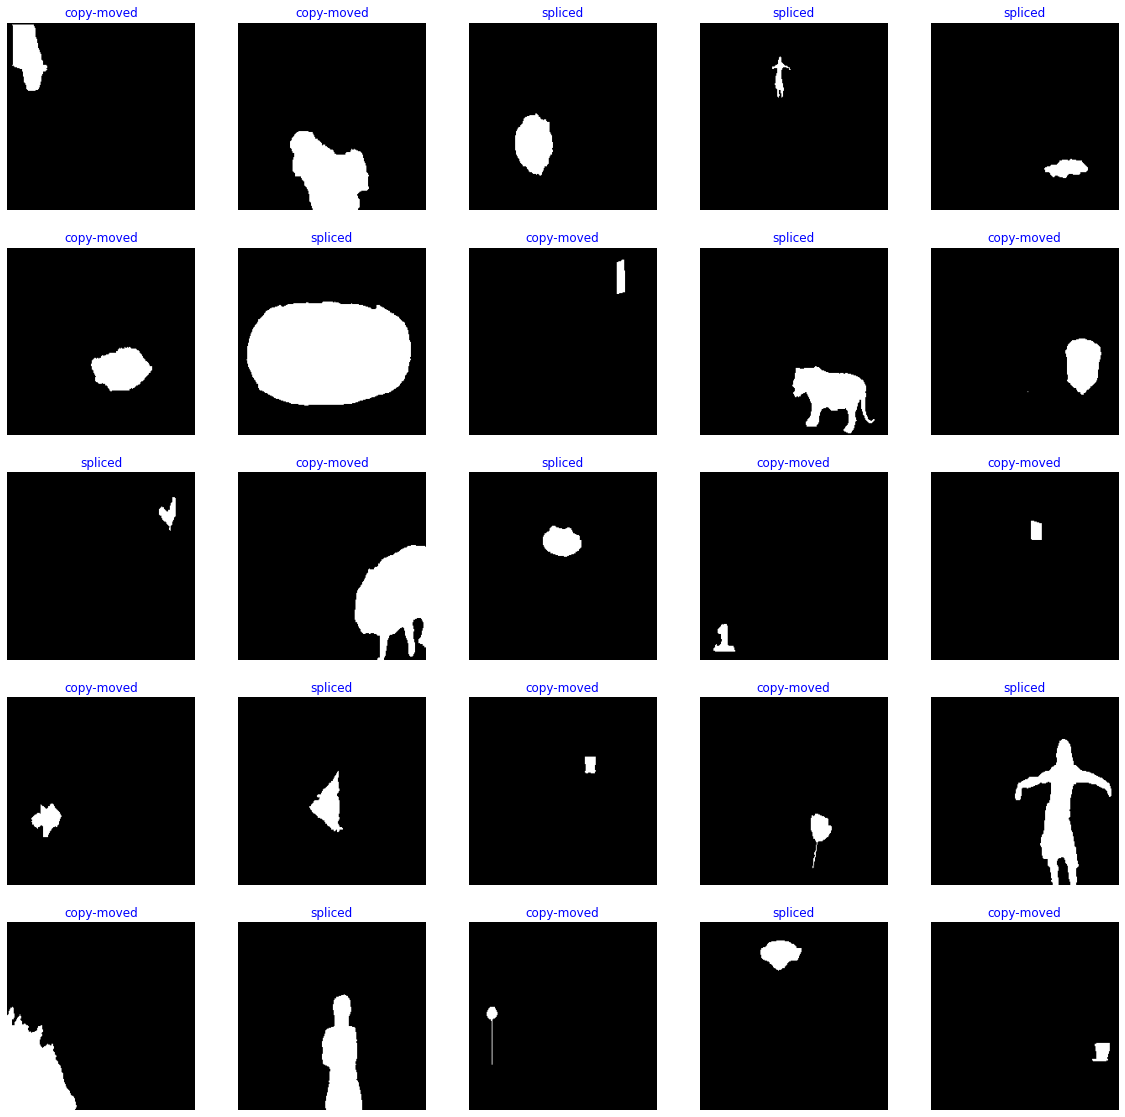

In [41]:
train_dir = '/kaggle/input/spoof-binary/spoof-binary/data/traindev'
test_dir = '/kaggle/input/spoof-binary/spoof-binary/data/test'
train_df, valid_df, test_df = split_data(train_dir, test_dir)

batch_size = 40
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [42]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 

base_model = tf.keras.applications.InceptionResNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])

model.compile(Adamax(learning_rate= 0.0019), loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
batch_normalization_815 (Bat (None, 1536)              6144      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 54,736,866
Trainable params: 54,673,250
Non-trainable params: 63,616
_________________________________________________________________


In [43]:
batch_size = 45     # set batch size for training
epochs = 100         # number of all epochs in training
patience = 5 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.97 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.3 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [44]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    5.982   68.075  105.79488 57.191   0.00190  0.00190  accuracy     0.00    47.17  
 2 /100    3.665   73.347   6.43981  76.589   0.00190  0.00190  accuracy     7.74    26.35  
 3 /100    2.518   75.523   2.67676  75.418   0.00190  0.00190  accuracy     2.97    26.27  
 4 /100    1.838   76.151   1.75624  76.923   0.00190  0.00190  accuracy     0.83    26.41  
 5 /100    1.401   78.243   1.28727  77.090   0.00190  0.00190  accuracy     2.75    26.41  
 6 /100    1.101   80.251   1.30396  75.251   0.00190  0.00190  accuracy     2.57    26.35  
 7 /100    0.900   81.339   0.97339  73.244   0.00190  0.00190  accuracy     1.36    26.35  
 8 /100    0.781   82.762   0.95251  74.582   0.00190  0.00190  accuracy     1.75    26.39  
 9 /100    0.668   84.226   0.86049  77.425   0.00190  0.00190  accuracy     1.77    26.20  
10 /100    0.583   85.900   0.81080  68.060   0.00190  0.00190  accurac

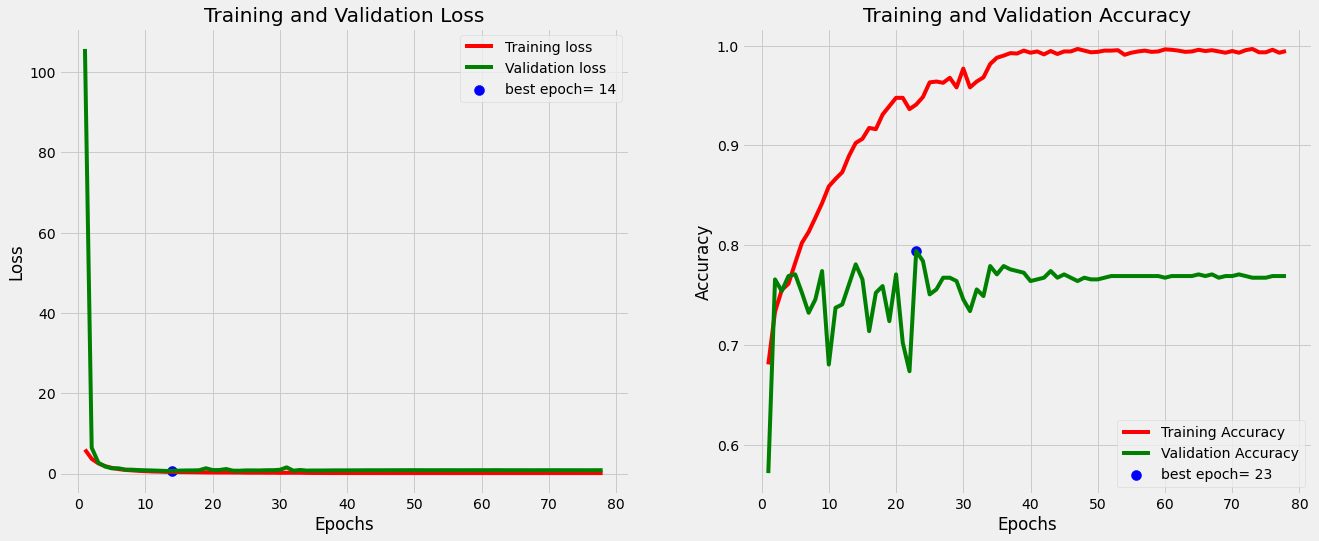

In [55]:
plot_training(history)

In [46]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

83/83 [==============================] - 4s 47ms/step - loss: 1.0446 - accuracy: 0.7048
Train Loss:  0.1675349920988083
Train Accuracy:  0.9694560766220093
--------------------
Validation Loss:  0.8295981884002686
Validation Accuracy:  0.7675585150718689
--------------------
Test Loss:  1.0446155071258545
Test Accuracy:  0.7048192620277405


In [47]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1
 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1]


Confusion Matrix, Without Normalization
[[117  49]
 [ 49 117]]
              precision    recall  f1-score   support

  copy-moved       0.70      0.70      0.70       166
     spliced       0.70      0.70      0.70       166

    accuracy                           0.70       332
   macro avg       0.70      0.70      0.70       332
weighted avg       0.70      0.70      0.70       332



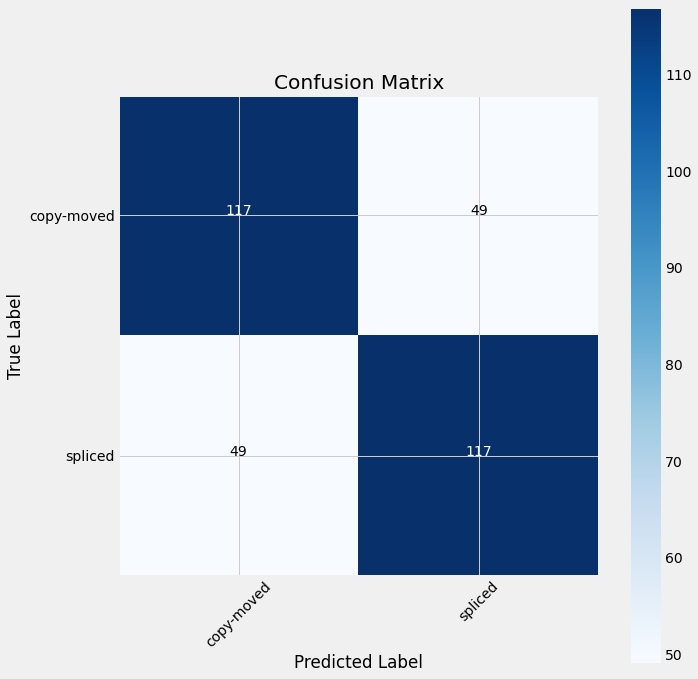

In [49]:
target_names = ['copy-moved', 'spliced']
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [50]:
model.save('model.h5')

In [51]:
model.save_weights('model-weights.h5')